<a href="https://colab.research.google.com/github/Abhilash437/Node2Vec-Movie-Recommender/blob/main/node2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install networkx

In [1]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
urlretrieve(
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip"
)
ZipFile("movielens.zip", "r").extractall()

In [3]:
movies = pd.read_csv("ml-latest-small/movies.csv")
movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")

ratings = pd.read_csv("ml-latest-small/ratings.csv")
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")

print("Movies shape: ", movies.shape)
print("Ratings shape: ", ratings.shape)

Movies shape:  (9742, 3)
Ratings shape:  (100836, 4)


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,movie_1,4.0,964982703
1,1,movie_3,4.0,964981247
2,1,movie_6,4.0,964982224
3,1,movie_47,5.0,964983815
4,1,movie_50,5.0,964982931


In [5]:
movies.head()

,movieId,title,genres
0,movie_1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,movie_2,Jumanji (1995),Adventure|Children|Fantasy
2,movie_3,Grumpier Old Men (1995),Comedy|Romance
3,movie_4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,movie_5,Father of the Bride Part II (1995),Comedy


In [6]:
def get_movie_title_by_id(movieId):
    return list(movies[movies.movieId == movieId].title)[0]


def get_movie_id_by_title(title):
    return list(movies[movies.title == title].movieId)[0]

In [7]:
min_rating = 5
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

In [8]:
ratings = ratings[ratings.rating >= min_rating]
movies_grouped_by_users = list(ratings.groupby("userId"))

for group in tqdm(movies_grouped_by_users, position=0, leave=True, desc="Computing movie rating frequencies"):
  current_movies = list(group[1]['movieId'])

  for i in range(len(current_movies)):
    item_frequency[current_movies[i]] += 1

    for j in range(i + 1, len(current_movies)):
      x = min(current_movies[i], current_movies[j])
      y = max(current_movies[i], current_movies[j])
      pair_frequency[(x, y)] += 1

Computing movie rating frequencies: 100%|██████████| 573/573 [00:00<00:00, 998.58it/s] 


In [9]:
min_weight = 10
D = math.log(sum(item_frequency.values()))

movies_graph = nx.Graph()

for pair in pair_frequency:
  x, y = pair
  xy_frequency = pair_frequency[pair]
  x_frequency = item_frequency[x]
  y_frequency = item_frequency[y]

  pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
  weight = pmi * xy_frequency

  if weight >= min_weight:
    movies_graph.add_edge(x, y, weight=weight)

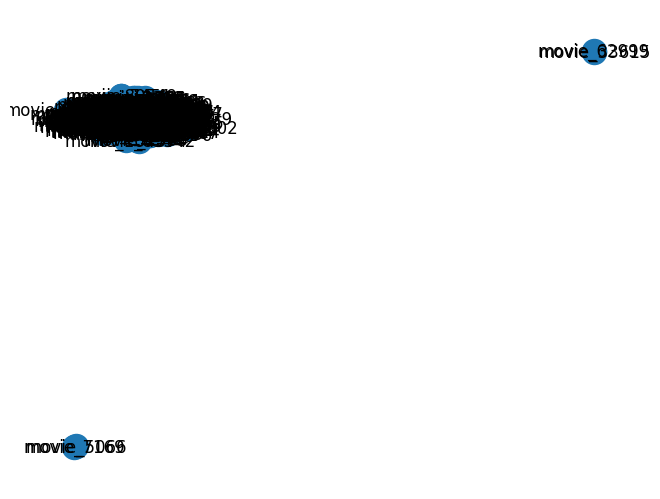

In [10]:
nx.draw_spring(movies_graph, with_labels=True)

In [11]:
print("Number of nodes in the graph: ", movies_graph.number_of_nodes())
print("Number of edges in the graph: ", movies_graph.number_of_edges())

Number of nodes in the graph:  1405
Number of edges in the graph:  40043


In [12]:
degrees = []

for node in movies_graph.nodes:
  degrees.append(movies_graph.degree(node))

print("Average degree: ", np.mean(degrees))
print("Avg: ", round(sum(degrees) / len(degrees)))

Average degree:  57.00071174377224
Avg:  57


In [13]:
vocabulary = ["NA"] + list(movies_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

In [14]:
def next(graph, current, previous, p, q):
  neighbours = list(graph.neighbors(current))

  weights = []

  for neighbour in neighbours:
    if neighbour == previous:
      weights.append(graph[current][neighbour]["weight"] / p)
    elif graph.has_edge(neighbour, previous):
      weights.append(graph[current][neighbour]["weight"])
    else:
      weights.append(graph[current][neighbour]["weight"] / q)

  weight_sum = sum(weights)
  probabilities = [weight / weight_sum for weight in weights]

  next = np.random.choice(neighbours, size=1, p=probabilities)[0]

  return next


def random_walk(graph, num_walks, num_steps, p, q):
  walks = []
  nodes = list(graph.nodes)

  for _ in range(num_walks):
    random.shuffle(nodes)

    for node in nodes:
      walk = [node]

      while len(walk) <= num_steps:
        current = walk[-1]
        previous = walk[-2] if len(walk) > 1 else None
        next_node = next(graph, current, previous, p, q)
        walk.append(next_node)

      walk = [vocabulary_lookup[node] for node in walk]

      walks.append(walk)

  return walks


In [15]:
# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 5
# Number of steps of each random walk.
num_steps = 10

walks = random_walk(movies_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))

Number of walks generated: 7025


In [16]:
def generate_examples(sequences, window_size, num_neg_samples, vocab_size):
  example_weights = defaultdict(int)

  for sequence in sequences:
    pairs, labels = keras.preprocessing.sequence.skipgrams(
      sequence,
      vocabulary_size=vocab_size,
      window_size=window_size,
      negative_samples=num_neg_samples,
    )

    for pair, label in zip(pairs, labels):
      target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
      if target == context:
        continue
      entry = (target, context, label)
      example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []

    for entry in example_weights:
      weight = example_weights[entry]
      target, context, label = entry

      targets.append(target)
      contexts.append(context)
      labels.append(label)
      weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


In [18]:
def generate_examples2(sequences, window_size, num_neg_samples, vocab_size):
  example_weights = defaultdict(int)

  for sequence in sequences:
    pairs, labels = keras.preprocessing.sequence.skipgrams(
      sequence,
      vocabulary_size=vocab_size,
      window_size=window_size,
      negative_samples=num_neg_samples,
    )

    for pair, label in zip(pairs, labels):
      target, context = max(pair[0], pair[1]), min(pair[0], pair[1])
      if target == context:
        continue
      entry = (target, context, label)
      example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []

    for entry in example_weights:
      weight = example_weights[entry]
      target, context, label = entry

      targets.append(target)
      contexts.append(context)
      labels.append(label)
      weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


In [19]:
num_negetive_samples = 10 # change this param
window_size = 10

targets, contexts, labels, weights = generate_examples(
  walks, window_size, num_negetive_samples, len(vocabulary)
)

In [20]:
print(f"Number of targets: {len(targets)}")
print(f"Number of contexts: {len(contexts)}")
print(f"Number of labels: {len(labels)}")
print(f"Number of weights: {len(weights)}")

Number of targets: 1121
Number of contexts: 1121
Number of labels: 1121
Number of weights: 1121


In [21]:
batch_size = 1024

def create_dataset(target, context, label, weight, batch_size):
  inputs = {
      "target": target,
      "context": context,
  }

  dataset = tf.data.Dataset.from_tensor_slices((inputs, label, weight))
  dataset = dataset.shuffle(buffer_size=batch_size * 2)
  dataset = dataset.batch(batch_size, drop_remainder=True)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

  return dataset


In [22]:
dataset = create_dataset(targets, contexts, labels, weights, batch_size)

In [42]:
learning_rate = 0.004 #0.01
embedding_dim = 40 #50
num_epochs = 20

In [43]:
def create_model(input_dim, embedding_dim):

  inputs = {
      "target": layers.Input(shape=(), name="target", dtype="int32"),
      "context": layers.Input(shape=(), name="context", dtype="int32")
  }

  embedding = layers.Embedding(
    input_dim=input_dim,
    output_dim=embedding_dim,
    name="item_embedding",
    embeddings_initializer="he_normal",
    # Use embeddings_regularizer instead of embedding_regularizer
    embeddings_regularizer=keras.regularizers.l2(1e-6)
  )
  target_embeding = embedding(inputs["target"])
  context_embeding = embedding(inputs["context"])

  dot_product = layers.Dot(axes=1, normalize=False, name="dot_product")( [target_embeding, context_embeding] )

  model = keras.Model(inputs=inputs, outputs=dot_product)

  return model

In [44]:
model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

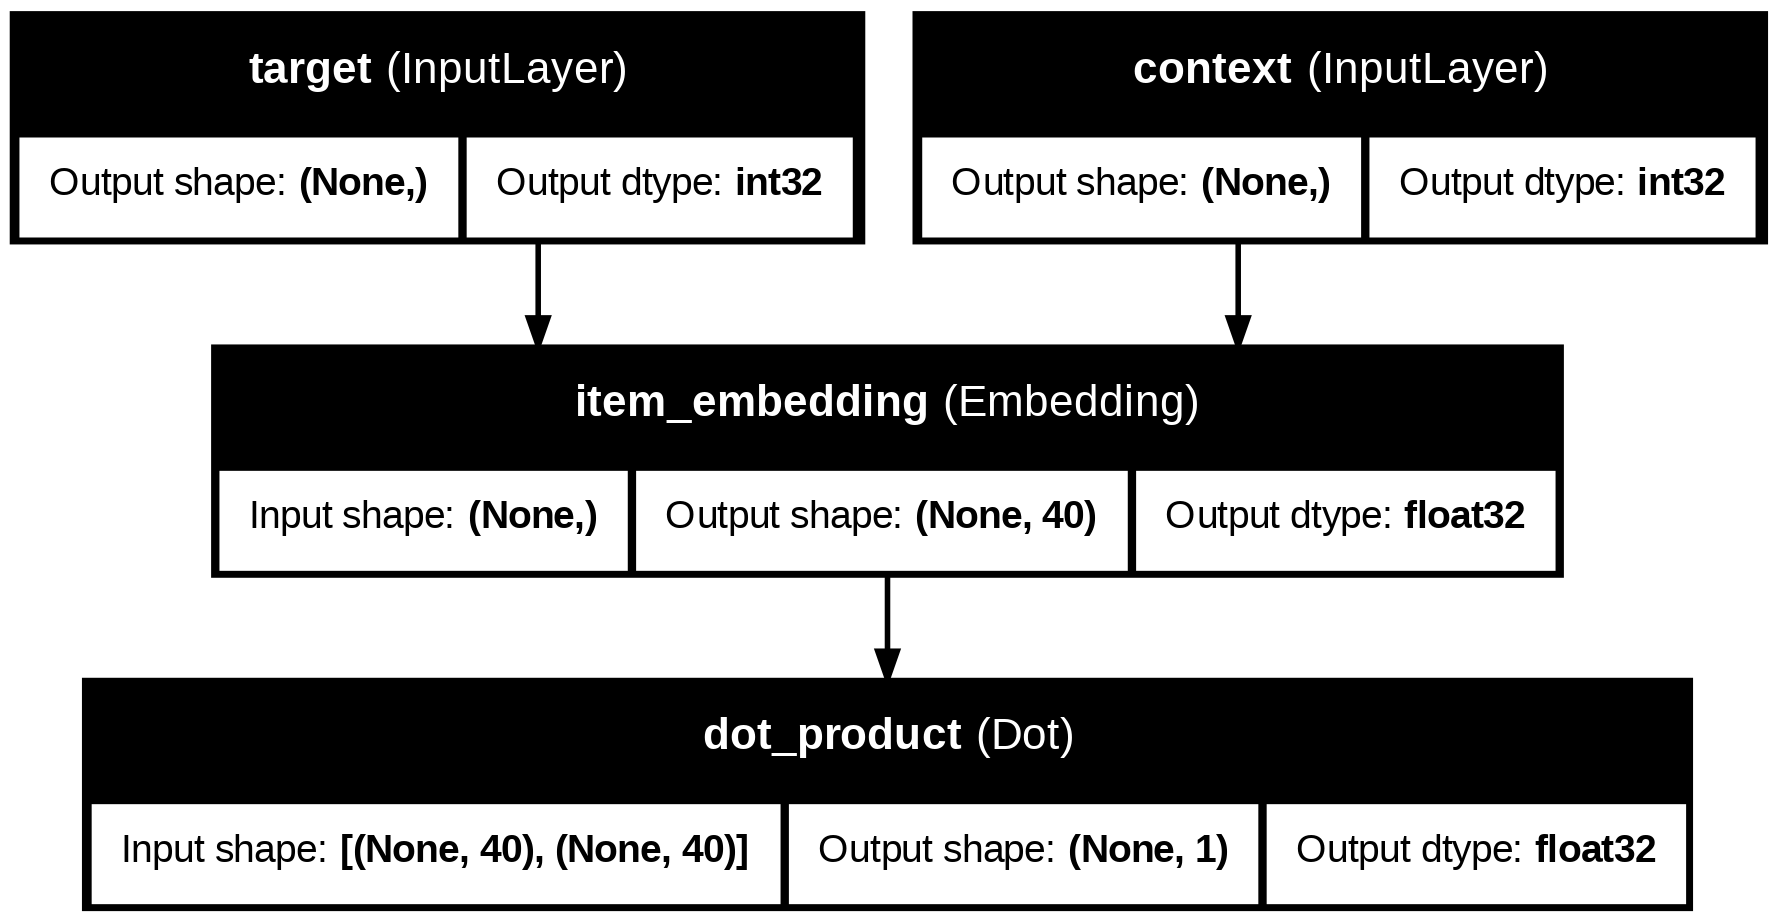

In [45]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
)

In [46]:
history = model.fit(dataset, epochs=num_epochs)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step - loss: 0.7487
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.7462
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.7463
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.7406
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.7407
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.7345
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.7318
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.7272
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7233
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.7186
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7145
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.7093
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7004
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.6962
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6894
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━

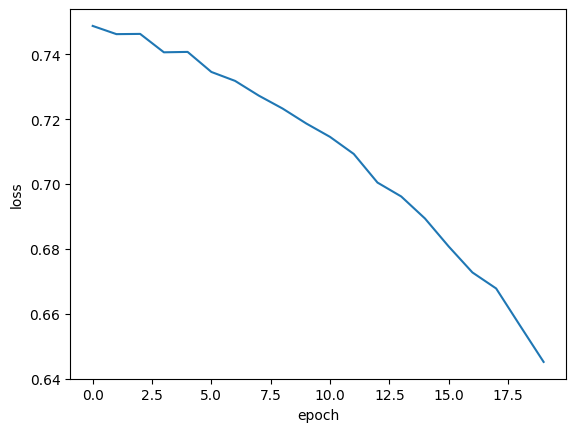

In [47]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [49]:
movie_embeddings = model.get_layer("item_embedding").get_weights()[0]
print("Embeddings shape:", movie_embeddings.shape)

Embeddings shape: (1406, 40)


In [50]:
query_movies = [
    "Matrix, The (1999)",
    "Star Wars: Episode IV - A New Hope (1977)",
    "Lion King, The (1994)",
    "Terminator 2: Judgment Day (1991)",
    "Godfather, The (1972)",
]

In [51]:
query_embeddings = []

for movie_title in query_movies:
    movieId = get_movie_id_by_title(movie_title)
    token_id = vocabulary_lookup[movieId]
    movie_embedding = movie_embeddings[token_id]
    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)

In [52]:
similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(movie_embeddings),
    transpose_b=True,
)

_, indices = tf.math.top_k(similarities, k=5)
indices = indices.numpy().tolist()

In [53]:
for idx, title in enumerate(query_movies):
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_movieId = vocabulary[token]
        similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_title}")
    print()

Matrix, The (1999)
------------------
- Matrix, The (1999)
- X2: X-Men United (2003)
- Bill & Ted's Excellent Adventure (1989)
- Departed, The (2006)
- Chicago (2002)

Star Wars: Episode IV - A New Hope (1977)
-----------------------------------------
- We're the Millers (2013)
- Star Wars: Episode IV - A New Hope (1977)
- Arsenic and Old Lace (1944)
- Commitments, The (1991)
- Solaris (Solyaris) (1972)

Lion King, The (1994)
---------------------
- Guess Who's Coming to Dinner (1967)
- City Slickers (1991)
- No Man's Land (2001)
- Lion King, The (1994)
- Hustler, The (1961)

Terminator 2: Judgment Day (1991)
---------------------------------
- Terminator 2: Judgment Day (1991)
- Crow, The (1994)
- Three Kings (1999)
- Godfather, The (1972)
- Labyrinth (1986)

Godfather, The (1972)
---------------------
- Godfather, The (1972)
- Terminator 2: Judgment Day (1991)
- Crow, The (1994)
- Monty Python and the Holy Grail (1975)
- Three Kings (1999)



In [54]:
import io

out_v = io.open("embeddings.tsv", "w", encoding="utf-8")
out_m = io.open("metadata.tsv", "w", encoding="utf-8")

for idx, movie_id in enumerate(vocabulary[1:]):
    movie_title = list(movies[movies.movieId == movie_id].title)[0]
    vector = movie_embeddings[idx]
    out_v.write("\t".join([str(x) for x in vector]) + "\n")
    out_m.write(movie_title + "\n")

out_v.close()
out_m.close()